# Infant resting state fMRI preprocessing
This notebook contains preprocessing tailored to infant resting state fMRI collected in 5-8 month olds. 

The processing steps for the fMRI broadly include:
* Slice-time correction
* Rigid realignment
* Co-registration to the sMRI (T2-weighted structural MRI)
* Co-registration to template
* De-noising to remove:
    - Mean timeseries for that voxel
    - Component noise associated with white matter and CSF- delete the GM and smooth what is left
    - Component noise associated with background signal - delete brain and smooth what's left
    - Component noise from the averaged timeseries
    - motion regressors
    - Motion derivatives (lagged 6 times)
    - Squared derivatives (lagged 6 times) as an exploratory
* Bandpass filtering

In [1]:
#import packages
from os import listdir, makedirs
from os.path import isdir
from nipype.interfaces.io import DataSink, SelectFiles, DataGrabber # Data i/o
from nipype.interfaces.utility import IdentityInterface, Function     # utility
from nipype.pipeline.engine import Node, Workflow, MapNode, JoinNode        # pypeline engine
from nipype.interfaces.nipy.preprocess import Trim
from nipype.interfaces.ants import N4BiasFieldCorrection
from nipype.interfaces.fsl import SliceTimer, MCFLIRT, FLIRT, BET, Merge
from nipype.interfaces.fsl.utils import Reorient2Std, MotionOutliers
from nipype.interfaces.fsl.maths import ApplyMask, MeanImage
from nipype.interfaces.freesurfer import Resample, Binarize
from nipype.algorithms.confounds import CompCor
from nipype.interfaces.afni.preprocess import Bandpass
from nipype.interfaces.afni.utils import AFNItoNIFTI
from pandas import DataFrame, Series,read_csv

#set output file type for FSL to NIFTI_GZ
from nipype.interfaces.fsl.preprocess import FSLCommand
FSLCommand.set_default_output_type('NIFTI_GZ')

# MATLAB setup - Specify path to current SPM and the MATLAB's default mode
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('~/spm12/toolbox')
MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

# Set study variables
#studyhome = '/Users/catcamacho/Box/SNAP/BABIES'
studyhome = '/home/camachocm2/Analysis/SNAP'
raw_data = studyhome + '/raw'
output_dir = studyhome + '/processed/preproc'
workflow_dir = studyhome + '/workflows'
subjects_info = read_csv(studyhome + '/misc/rest_subjects_info.csv',index_col=None, dtype={'subject_id':str})
subjects_info['subject_id'] = subjects_info['subject_id'].apply(lambda x: x.zfill(4))
subjects_list = subjects_info['subject_id'].tolist()

template_brain = studyhome + '/templates/6mo_T2w_template_2mm.nii.gz'
template_mask = studyhome + '/templates/6mo_T2w_template_2mm_mask.nii.gz'
template_gmmask = studyhome + '/templates/6mo_T2w_template_2mm_gm.nii.gz'
template_nongm = studyhome + '/templates/6mo_T2w_template_2mm_nongm.nii.gz'
template_nonbrain = studyhome + '/templates/6mo_T2w_template_2mm_nonbrainD1.nii.gz'
template_maskD1 = studyhome + '/templates/6mo_T2w_template_2mm_maskD1.nii.gz'


proc_cores = 2 # number of cores of processing for the workflows

vols_to_trim = 4
interleave = False
TR = 2.5 # in seconds
slice_dir = 3 # 1=x, 2=y, 3=z
resampled_voxel_size = (2,2,2)
fwhm = 4 #fwhm for smoothing with SUSAN
anat_type='t2'

#changed to match Pendl et al 2017 (HBM)
highpass_freq = 0.005 #in Hz
lowpass_freq = 0.1 #in Hz

191125-08:58:16,786 nipype.utils INFO:
	 Running nipype version 1.2.3 (latest: 1.3.1)


In [2]:
## File handling Nodes

# Identity node- select subjects
infosource = Node(IdentityInterface(fields=['subject_id']),
                     name='infosource')
infosource.iterables = ('subject_id', subjects_list)

# Datasink- where our select outputs will go
substitutions = [('_subject_id_', '')]
datasink = Node(DataSink(), name='datasink')
datasink.inputs.base_directory = output_dir
datasink.inputs.container = output_dir
datasink.inputs.substitutions = substitutions

## Preprocess T2w anatomical images
These nodes and workflow (anat_preprocflow) performs N4 bias correction and skullstripping.

In [ ]:
## File handling nodes

template={'anat': raw_data + '/%s*/t2w*.nii.gz'}
selectfiles = Node(DataGrabber(sort_filelist=True,
                               template = raw_data + '/%s*/t2w*.nii.gz',
                               field_template = template,
                               base_directory=raw_data,
                               infields=['subject_id'],
                               template_args={'anat':[['subject_id']]}),
                   name='selectfiles')

n4biascorr = Node(N4BiasFieldCorrection(dimension=3,
                                        output_image='{0}_nucorrect.nii.gz'.format(anat_type)), 
                  name='n4biascorr')

skullstrip = Node(BET(out_file='{0}_nucorrect_strip.nii.gz'.format(anat_type)), name='skullstrip')

In [ ]:
anat_preprocflow = Workflow(name='anat_preprocflow')
anat_preprocflow.connect([(infosource,selectfiles, [('subject_id','subject_id')]),
                          (selectfiles, n4biascorr, [('anat','input_image')]),
                          (n4biascorr, skullstrip, [('output_image','in_file')]),
                          
                          (n4biascorr, datasink, [('output_image','nu_corrected_anat')]),
                          (skullstrip, datasink, [('out_file','skullstripped_anat')])
                         ])

anat_preprocflow.base_dir = workflow_dir
anat_preprocflow.write_graph(graph2use='flat')
anat_preprocflow.run('MultiProc', plugin_args={'n_procs': 10, 'memory_gb':30})

## Preprocess fMRI resting state data
These nodes and workflow (preprocflow) perform basic preprocessing to align the functional volumes into a common space.
1. Reorient images to standard space
2. Reslice the structural image to 2mm isotropic
3. Functional image slice time correction
4. Rigid realignment to first volume of functional image
5. Coregistration of functional images to structural image
6. Coregistration of functional images to template image
7. Trim first 4 volumes of the functional images to remove pre-steady-state images

In [ ]:
## File handling Nodes

# Data grabber- select sMRI
anat_template = {'struct': output_dir + '/skullstripped_anat/{subject_id}/t2_nucorrect_strip.nii.gz'}
selectanat = Node(SelectFiles(anat_template), name='selectfiles')

# Data grabber- select fMRI
func_template = {'func':raw_data + '/%s*/rest*.nii.gz'}
selectfunc = Node(DataGrabber(sort_filelist=True,
                              template = raw_data + '/%s*/rest*.nii.gz',
                              field_template = func_template,
                              base_directory=raw_data,
                              infields=['subject_id'], 
                              template_args={'func':[['subject_id']]}), name='selectfunc')

In [ ]:
# Data QC nodes
def create_coreg_plot(epi,anat):
    import os
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from nilearn import plotting
    from nipype.interfaces.nipy.preprocess import Trim
    from os.path import abspath
    
    tr = Trim()
    tr.inputs.in_file = epi[0]
    tr.inputs.end_index = 1
    tr.inputs.out_file = 'firstvol.nii.gz'
    tr.run()
    
    epi = abspath('firstvol.nii.gz')
    
    coreg_filename='coregistration.png'
    display = plotting.plot_anat(epi, display_mode='ortho',
                                 draw_cross=False,
                                 title = 'coregistration to anatomy')
    display.add_edges(anat)
    display.savefig(coreg_filename) 
    display.close()
    coreg_file = os.path.abspath(coreg_filename)
    
    return(coreg_file)

def check_mask_coverage(epi,brainmask):
    import os
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from nilearn import plotting
    
    from nipype.interfaces.nipy.preprocess import Trim
    from os.path import abspath
    
    tr = Trim()
    tr.inputs.in_file = epi[0]
    tr.inputs.end_index = 1
    tr.inputs.out_file = 'firstvol.nii.gz'
    tr.run()
    
    epi = abspath('firstvol.nii.gz')
    
    maskcheck_filename='maskcheck.png'
    display = plotting.plot_anat(epi, display_mode='ortho',
                                 draw_cross=False,
                                 title = 'brainmask coverage')
    display.add_contours(brainmask,levels=[.5], colors='r')
    display.savefig(maskcheck_filename)
    display.close()
    maskcheck_file = os.path.abspath(maskcheck_filename)

    return(maskcheck_file)

make_coreg_img = Node(name='make_coreg_img',
                      interface=Function(input_names=['epi','anat'],
                                         output_names=['coreg_file'],
                                         function=create_coreg_plot))

make_checkmask_img = Node(name='make_checkmask_img',
                      interface=Function(input_names=['epi','brainmask'],
                                         output_names=['maskcheck_file'],
                                         function=check_mask_coverage))

make_checkmask_img.inputs.brainmask = template_gmmask

In [ ]:
## Nodes for preprocessing

# Reorient to standard space using FSL
reorientfunc = MapNode(Reorient2Std(), name='reorientfunc', iterfield=['in_file'])
reorientstruct = Node(Reorient2Std(), name='reorientstruct')

# Reslice- using MRI_convert 
reslice_struct = Node(Resample(voxel_size=resampled_voxel_size), name='reslice_struct')

#Slice timing correction based on interleaved acquisition using FSL
slicetime_correct = MapNode(SliceTimer(interleaved=interleave, 
                                       slice_direction=slice_dir,
                                       time_repetition=TR, 
                                       out_file='st_func.nii.gz'),
                            name='slicetime_correct', iterfield=['in_file'])
# Rigid realignment
realign = MapNode(MCFLIRT(save_plots=True,out_file='rest_moco.nii.gz'), name='realign', iterfield=['in_file'])

# Registration- using FLIRT
# The BOLD image is 'in_file', the anat is 'reference', the output is 'out_file'
firstvol = MapNode(Trim(end_index=1), name='firstvol',iterfield=['in_file'])
coreg1 = MapNode(FLIRT(), name='coreg1', iterfield=['in_file'])
coreg2 = MapNode(FLIRT(apply_xfm=True), name='coreg2', iterfield=['in_file','in_matrix_file'])

# Registration
register_template = Node(FLIRT(reference=template_brain, 
                               out_file='preproc_anat.nii.gz'), 
                         name='register_template')

xfmFUNC = MapNode(FLIRT(reference=template_brain,apply_xfm=True, out_file='realigned_func.nii.gz'), 
                  name='xfmFUNC', iterfield=['in_file'])

trim = MapNode(Trim(begin_index=4, out_file='realigned_func.nii.gz'), name='trim', iterfield=['in_file'])

In [ ]:
## Preprocessing Workflow

preprocflow = Workflow(name='preprocflow')
preprocflow.connect([(infosource,selectanat,[('subject_id','subject_id')]), 
                     (infosource,selectfunc,[('subject_id','subject_id')]), 
                     (selectanat,reorientstruct,[('struct','in_file')]),
                     
                     (reorientstruct,reslice_struct,[('out_file','in_file')]),
                     (reslice_struct,coreg1,[('resampled_file','reference')]),
                     (reslice_struct,coreg2,[('resampled_file','reference')]),
                     (reslice_struct,register_template,[('resampled_file','in_file')]),
                     
                     (selectfunc,reorientfunc,[('func','in_file')]),
                     (reorientfunc,trim,[('out_file','in_file')]),
                     (trim, slicetime_correct,[('out_file','in_file')]),
                     (slicetime_correct, realign, [('slice_time_corrected_file','in_file')]),
                     (realign,firstvol,[('out_file','in_file')]),
                     (firstvol,coreg1,[('out_file','in_file')]),
                     (realign,coreg2,[('out_file','in_file')]),
                     (coreg1,coreg2,[('out_matrix_file', 'in_matrix_file')]),
                     (register_template,xfmFUNC,[('out_matrix_file','in_matrix_file')]),
                     (coreg2,xfmFUNC,[('out_file','in_file')]),
                     
                     (reorientstruct,make_coreg_img,[('out_file','anat')]),
                     (coreg1,make_coreg_img,[('out_file','epi')]),
                     (xfmFUNC,make_checkmask_img,[('out_file','epi')]),
                     (make_checkmask_img,datasink,[('maskcheck_file','maskcheck_image')]),
                     (make_coreg_img,datasink,[('coreg_file','coreg_image')]),
                   
                     (realign, datasink,[('par_file','motion_parameters')]),
                     (register_template,datasink,[('out_file','proc_struct')]),
                     (xfmFUNC, datasink, [('out_file','registered_func')])
                    ])
preprocflow.base_dir = workflow_dir
preprocflow.write_graph(graph2use='flat')
preprocflow.run('MultiProc', plugin_args={'n_procs': proc_cores})

## Create Nuissance Regressors
These nodes and workflow creates both the subject specific and general nuissance regressors needed for preprocessing the rest data per the process developed by David Montez. 

In [ ]:
# Data grabber- select fMRI
func_template = {'func':output_dir + '/registered_func/%s/*/realigned_func.nii.gz'}
selectfunc = Node(DataGrabber(sort_filelist = True,
                              template = output_dir + '/registered_func/%s/*/realigned_func.nii.gz',
                              field_template = func_template,
                              base_directory = output_dir,
                              infields=['subject_id'], 
                              template_args = {'func':[['subject_id']]}), name='selectfunc')

# select motion params
mot_template={'motion':output_dir + '/motion_parameters/%s/*/rest_moco.nii.gz.par'}
selectmotion = Node(DataGrabber(sort_filelist = True,
                                template = output_dir + '/motion_parameters/%s/*/rest_moco.nii.gz.par',
                                field_template = mot_template,
                                base_directory = output_dir,
                                infields = ['subject_id'], 
                                template_args = {'motion':[['subject_id']]}), name='selectmotion')     

In [ ]:
def mask_blur_func(mask, in_file):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath
    from numpy import median, where
    from nipype.interfaces.fsl import ApplyMask
    from glob import glob
    from subprocess import check_call

    applymask = ApplyMask()
    applymask.inputs.mask_file = mask
    applymask.inputs.in_file = in_file
    applymask.inputs.out_file = 'masked_file.nii.gz'
    applymask.inputs.nan2zeros = True
    applymask.run()

    masked_file = abspath('masked_file.nii.gz')
    
    
    if 'nonbrain' in mask:
        check_call(['gunzip',masked_file])
        
        from nipype.interfaces.spm import Smooth
        smooth = Smooth()
        smooth.inputs.in_files = 'masked_file.nii'
        smooth.inputs.fwhm = [22,4,4]
        smooth.inputs.out_prefix = 'blurred_'
        smooth.run()
        check_call(['gzip','blurred_masked_file.nii'])
        
    else:
        from nipype.interfaces.fsl import Smooth
        smooth = Smooth()
        smooth.inputs.in_file = masked_file
        smooth.inputs.smoothed_file = 'blurred_masked_file.nii.gz'
        smooth.inputs.fwhm = 4
        smooth.run()

    blurred_masked_file = abspath('blurred_masked_file.nii.gz')

    return(blurred_masked_file)

def leadlagmatrix(motion_file):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath
    import numpy as np

    motion_params = np.loadtxt(motion_file, dtype=float)
    trs = motion_params.shape[0]
    params = motion_params.shape[1]
    derivatives = np.gradient(motion_params, axis=0)
    leadlagderivs = np.zeros((trs,params*6))
    derivativessq = derivatives**2
    leadlagderivssq = np.zeros((trs,params*6))

    for i in range(0,params):
        for j in range(0,6):
            leadlagderivs[:,j+params*i] =  np.roll(derivatives[:,i],shift=j, axis=0)
            leadlagderivs[:j,j+params*i] = 0

    for i in range(0,params):
        for j in range(0,6):
            leadlagderivssq[:,j+params*i] =  np.roll(derivativessq[:,i],shift=j, axis=0)
            leadlagderivssq[:j,j+params*i] = 0

    np.savetxt('derivsleadlag.txt', leadlagderivs)
    np.savetxt('derivssqleadlag.txt', leadlagderivssq)

    leadlagderivsmot = abspath('derivsleadlag.txt')
    leadlagderivssqmot = abspath('derivssqleadlag.txt')
    
    return(leadlagderivsmot, leadlagderivssqmot)

In [ ]:
# get scanner noise
session_noise = MapNode(Function(input_names=['mask','in_file'], 
                                 output_names=['blurred_masked_file'],
                                 function=mask_blur_func), name='session_noise', iterfield=['in_file'])
session_noise.inputs.mask=template_nonbrain

# get noise associated with WM and CSF
wmcsf_noise = MapNode(Function(input_names=['mask','in_file'], 
                               output_names=['blurred_masked_file'],
                               function=mask_blur_func), name='wmcsf_noise', iterfield=['in_file'])
wmcsf_noise.inputs.mask=template_nongm

# extract components from session nifti
comp_session_noise = MapNode(CompCor(repetition_time=TR,
                                  num_components=9,
                                  components_file='components.txt',
                                  mask_files=template_mask), 
                          name='comp_session_noise', iterfield=['realigned_file'])

# extract components from WM-CSF nifti 
comp_wmcsf_noise = MapNode(CompCor(repetition_time=TR, 
                                   num_components=9,
                                   components_file='components.txt',
                                   mask_files=template_mask), 
                           name='comp_wmcsf_noise', iterfield=['realigned_file'])

# prepare leadlag motion and derivatives
prep_motion = MapNode(Function(input_names=['motion_file'], 
                               output_names=['leadlagderivsmot','leadlagderivssqmot'],
                               function=leadlagmatrix), 
                      name='prep_motion', iterfield=['motion_file'])

In [ ]:
create_noise_flow = Workflow(name='create_noise_flow')
create_noise_flow.connect([(infosource,selectfunc,[('subject_id','subject_id')]),
                           (selectfunc, wmcsf_noise, [('func','in_file')]),
                           (selectfunc, session_noise, [('func','in_file')]),
                           (wmcsf_noise, comp_wmcsf_noise, [('blurred_masked_file','realigned_file')]),
                           (session_noise, comp_session_noise, [('blurred_masked_file','realigned_file')]),
                           (wmcsf_noise, datasink, [('blurred_masked_file','wmcsf_noise_file')]),
                           (session_noise, datasink, [('blurred_masked_file','session_noise_file')]),
                           (comp_wmcsf_noise, datasink, [('components_file','subject_wmcsf_comp_noise')]),
                           (comp_session_noise, datasink, [('components_file','subject_session_comp_noise')]),
                           
                           (infosource,selectmotion,[('subject_id','subject_id')]),
                           (selectmotion, prep_motion, [('motion','motion_file')]),
                           (prep_motion, datasink, [('leadlagderivsmot','leadlagderivsmotion'),
                                                    ('leadlagderivssqmot','leadlagderivs_squaremotion')])
                          ])
create_noise_flow.base_dir = workflow_dir
create_noise_flow.write_graph(graph2use='flat')
create_noise_flow.run('MultiProc', plugin_args={'n_procs': 4})

### Create mean volume and extract the first 9 principle components

In [ ]:
from glob import glob
from nipype import config, logging
config.enable_debug_mode()
logging.update_logging(config)
from os import mkdir, remove
from os.path import abspath
from nibabel import load, save, Nifti1Image
import numpy as np
from subprocess import check_call

mkdir(output_dir + '/mean_func')
mf_output_dir = output_dir + '/mean_func'

in_files = glob(output_dir + '/registered_func/*/*/realigned_func.nii.gz')
    
image = load(in_files[0])
data = image.get_data()
data = np.expand_dims(data,4)
maxt = data.shape[3]

for a in range(1,len(in_files)):
    tempimg = load(in_files[a])
    tempdata = tempimg.get_data()
    if tempdata.shape[3] > maxt:
        maxt=tempdata.shape[3]

files_to_avg = []        

for a in range(0,len(in_files)):
    tempimg = load(in_files[a])
    tempdata = tempimg.get_data()
    if tempdata.shape[3] < maxt:
        padn=data.shape[3]-tempdata.shape[3]
        tempdata=np.pad(tempdata,pad_width=((0,0),(0,0),(0,0),(0,padn)),
                        mode='constant',constant_values=0)
        new_img = Nifti1Image(tempdata, affine=tempimg.affine, header=tempimg.header)
        save(new_img, 'realigned_func_pad_{0}.nii.gz'.format(a))
        files_to_avg.append(abspath('realigned_func_pad_{0}.nii.gz'.format(a)))
    elif tempdata.shape[3] == maxt:
        files_to_avg.append(in_files[a])
        
mean_file=mf_output_dir+'/mean_funcs.nii.gz'

check_call(['3dMean','-prefix',mean_file,'-non_zero'] +files_to_avg)

In [ ]:
# extract components from averaged time series
comp_average_noise = CompCor()
comp_average_noise.inputs.realigned_file=mean_file
comp_average_noise.inputs.repetition_time=TR
comp_average_noise.inputs.num_components=9
comp_average_noise.inputs.components_file=mf_output_dir +'/components.txt' 
comp_average_noise.inputs.mask_files=template_mask
comp_average_noise.run()

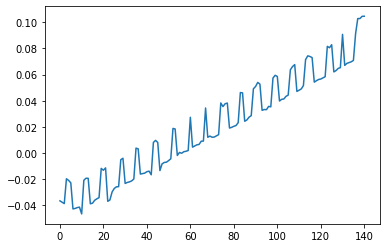

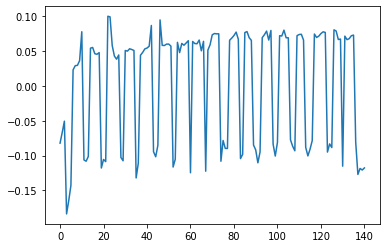

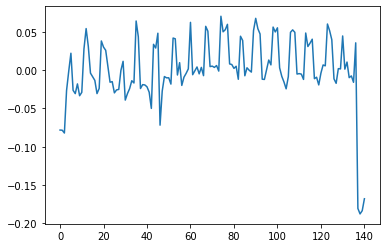

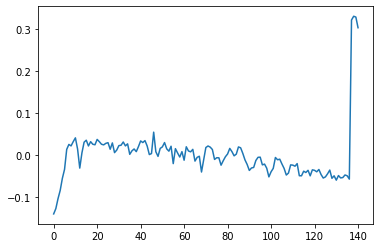

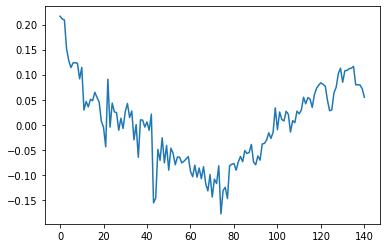

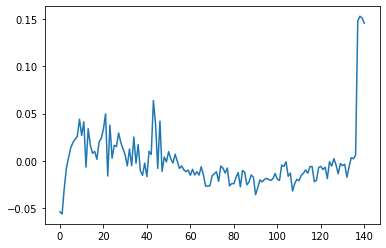

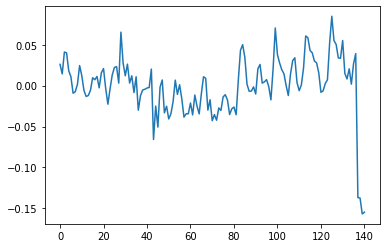

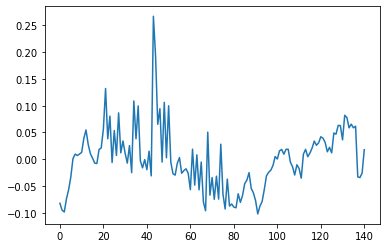

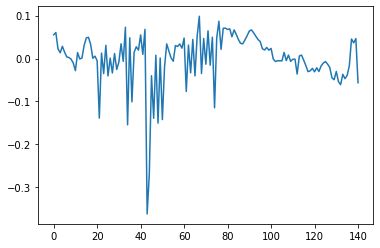

In [4]:
import matplotlib.pyplot as plt
from pandas import read_csv

components = read_csv(output_dir + '/mean_func/components.txt', index_col=None, delimiter='\t')

for comp in components.columns:
    plt.figure()
    plt.plot(components[comp])
    plt.show()
    plt.close()

## Movement Noise Evaluation Workflow

The nodes and workflow below (eval_noise_flow) is designed to take the nuissance regressors created in the previous section (create_noise_flow) and perform voxel-specific assessment of noise.  This is accomplished through the following steps:
1. Create unique design matrix for each 3D voxel
2. Perform a GLM for that voxel
3. Project results back into 3D space

In [ ]:
sub_files_template={'motion': output_dir + '/motion_parameters/{subject_id}/_realign{runnum}/rest_moco.nii.gz.par', 
                    'leadlagderivsmotion': output_dir + '/leadlagderivsmotion/{subject_id}/_prep_motion{runnum}/derivsleadlag.txt', 
                    'leadlagderivs_squaremotion': output_dir + '/leadlagderivs_squaremotion/{subject_id}/_prep_motion{runnum}/derivssqleadlag.txt', 
                    'func': output_dir + '/registered_func/{subject_id}/_xfmFUNC{runnum}/realigned_func.nii.gz'}
select_sub_files=Node(SelectFiles(sub_files_template),name='select_sub_files')
select_sub_files.iterables=('runnum',['0','1'])

In [ ]:
def org_shared_noise(motion, leadlagderivsmotion, leadlagderivs_squaremotion):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from numpy import loadtxt, concatenate
    from pandas import DataFrame
    from os.path import abspath
    
    noise_list = []
    for file in [motion, leadlagderivsmotion, leadlagderivs_squaremotion]:
        mo = loadtxt(file, dtype=float, comments=None)
        length_of_file = mo.shape[0]
        noise_list.append(mo)

    shared_noise_data = concatenate(noise_list,axis=1)
    
    col_names = ['noise_{0}'.format(a) for a in range(0,shared_noise_data.shape[1])] 
    
    shared_noise = DataFrame(shared_noise_data, columns=col_names)
    shared_noise.to_csv('shared_noise.csv')
    shared_noise_file = abspath('shared_noise.csv')
    return(shared_noise_file)

def voxelwise_p_eta(func,shared_noise_file,mean_func,mask):
    from os.path import abspath
    from numpy import zeros, ones
    from numpy.linalg import lstsq
    from pandas import read_csv, Series
    from nilearn.masking import apply_mask, unmask

    # import data into an array that is timepoints (rows) by voxel number (columns)
    shared_noise = read_csv(shared_noise_file, index_col=0)
    func_data = apply_mask(func, mask)
    mean_func_data = apply_mask(mean_func, mask)
    mean_func_data = mean_func_data[:func_data.shape[0],:]
    coefficients = zeros((shared_noise.shape[1]+2,func_data.shape[1]))
    num_regress_groups = int((shared_noise.shape[1]-6)/3)
    p_eta_data = zeros((num_regress_groups,func_data.shape[1]))

    # perform voxel-wise matrix inversion
    for x in range(0,func_data.shape[1]):
        shared_noise['mean_signal'] = mean_func_data[:,x]
        shared_noise['constant'] = 1
        noise_mat = shared_noise.to_numpy()
        y = func_data[:,x]
        solution = lstsq(noise_mat,y)
        coefficients[:,x] = solution[0]
        r2 = 1 - solution[1] / (shared_noise.shape[0] * y.var())
        for i in range(0,num_regress_groups):
            temp = shared_noise.drop(['noise_{0}'.format(3*i+6),'noise_{0}'.format(3*i+7),'noise_{0}'.format(3*i+8)],axis=1)
            temp_mat = temp.to_numpy()
            temp_sol = lstsq(temp_mat,y)
            temp_r2 = 1 - temp_sol[1] / (temp_mat.shape[0] * y.var())
            p_eta_data[i,x] = r2-temp_r2  

    coeff_image = unmask(coefficients, mask)
    coeff_image.to_filename('weights.nii.gz')
    p_eta_image = unmask(p_eta_data, mask)
    p_eta_image.to_filename('p_eta.nii.gz')
    sample_design_df = shared_noise.to_csv('last_noise_mat.csv')

    weights = abspath('weights.nii.gz')
    p_eta = abspath('p_eta.nii.gz')
    sample_design_df = abspath('last_noise_mat.csv')

    return(weights,p_eta, sample_design_df)

In [ ]:
compile_noise_mat = Node(Function(input_names=['motion', 'leadlagderivsmotion', 'leadlagderivs_squaremotion'],
                                  output_names=['shared_noise_file'],
                                  function=org_shared_noise), 
                         name='compile_noise_mat')
eval_noise_func = Node(Function(input_names=['func','shared_noise_file','mean_func','mask'], 
                                output_names=['weights','p_eta','sample_design_df'],
                                function=voxelwise_p_eta),
                       name='eval_noise_func')
eval_noise_func.inputs.mask = template_maskD1
eval_noise_func.inputs.mean_func = output_dir + '/mean_func/mean_funcs.nii.gz'

In [ ]:
eval_noise_flow = Workflow(name='eval_noise_flow')
eval_noise_flow.connect([(infosource, select_sub_files,[('subject_id','subject_id')]),
                         (select_sub_files, eval_noise_func, [('func','func')]),
                         (select_sub_files, compile_noise_mat, [('motion','motion'),
                                                                ('leadlagderivsmotion','leadlagderivsmotion'), 
                                                                ('leadlagderivs_squaremotion','leadlagderivs_squaremotion')]),
                         (compile_noise_mat, eval_noise_func, [('shared_noise_file','shared_noise_file')]),
                         
                         (compile_noise_mat, datasink, [('shared_noise_file','shared_noise_file')]),
                         (eval_noise_func,datasink,[('weights','denoising_weights'),
                                                    ('sample_design_df','denoise_sample_design_df'),
                                                    ('p_eta','p_eta')])
                        ])
eval_noise_flow.base_dir = workflow_dir
eval_noise_flow.write_graph(graph2use='flat')
eval_noise_flow.run('MultiProc', plugin_args={'n_procs': 3})

### Assess which motion parameters are associated with systematic noise

In [ ]:
# create mean of the parameter estimates for the noise variables

from subprocess import check_call
from glob import glob
files_to_avg = glob(output_dir + '/denoising_weights/*/*/weights.nii.gz')
check_call(['3dMean','-prefix',output_dir + '/mean_weights/mean_noise_estimates.nii.gz','-non_zero'] +files_to_avg)

files_to_avg = glob(output_dir + '/partial_eta_mot_params/*/*/p_eta_sq.nii.gz')
check_call(['3dMean','-prefix',output_dir + '/mean_partial_r2/mean_p_eta_estimates.nii.gz','-non_zero'] +files_to_avg)

/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


[0.01436467 0.01173707 0.01323306 0.01147777 0.01283382 0.01137621
 0.01293239 0.01115672 0.01547054 0.01209233 0.01556914 0.01213761
 0.01245962 0.0115273  0.01183556 0.01134386 0.01197873 0.01243476
 0.01196763 0.01135478 0.01271851 0.01237741 0.01250789 0.01182066]
[7, 15, 19, 5, 3, 13]


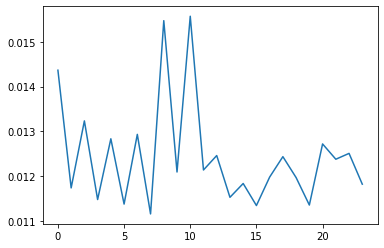

In [5]:
from nilearn.masking import apply_mask
import matplotlib.pyplot as plt
from numpy import mean

p_eta_data = apply_mask(output_dir + '/mean_partial_r2/mean_p_eta_estimates.nii.gz', template_gmmask)
mean_p_etas = mean(p_eta_data, axis=1)
print(mean_p_etas)
indices_to_drop = sorted(range(len(mean_p_etas)), key=lambda i: mean_p_etas[i])[:6]
print(indices_to_drop)

noise_to_drop = []
for i in indices_to_drop:
    noise_to_drop.append('noise_{0}'.format(3*i+6))
    noise_to_drop.append('noise_{0}'.format(3*i+7))
    noise_to_drop.append('noise_{0}'.format(3*i+8))
plt.plot(mean_p_etas)

## Final Denoising Workflow

In [18]:
sub_files_template={'func': output_dir + '/registered_func/{subject_id}/_xfmFUNC{runnum}/realigned_func.nii.gz',
                    'shared_noise_file': output_dir + '/shared_noise_file/{subject_id}/_runnum_{runnum}/shared_noise.csv',
                    'session_noise':  output_dir + '/session_noise_file/{subject_id}/_session_noise{runnum}/blurred_masked_file.nii.gz',
                    'wmcsf_noise':  output_dir + '/wmcsf_noise_file/{subject_id}/_wmcsf_noise{runnum}/blurred_masked_file.nii.gz'}
select_sub_files=Node(SelectFiles(sub_files_template),name='select_sub_files')
select_sub_files.iterables=('runnum',['0','1'])

In [19]:
def voxelwise_glm(func,shared_noise_file,mean_func,mask,noise_to_drop,session_noise,wmcsf_noise):
    from os.path import abspath
    from numpy import zeros, dot, transpose, sum
    from numpy.linalg import pinv
    from pandas import read_csv, Series
    from nilearn.masking import apply_mask, unmask

    shared_noise = read_csv(shared_noise_file, index_col=0)
    shared_noise.drop(labels=noise_to_drop, inplace=True, axis=1)
    
    # import data into an array that is timepoints (rows) by voxel number (columns)
    func_data = apply_mask(func, mask)
    wmcsf_data = apply_mask(wmcsf_noise, mask)
    session_data = apply_mask(session_noise, mask)
    mean_func_data = apply_mask(mean_func, mask)
    mean_func_data = mean_func_data[:func_data.shape[0],:]
    
    #preallocate matrices for output data
    coefficients = zeros((shared_noise.shape[1]+4,func_data.shape[1]))
    resid_data = zeros(func_data.shape)

    # perform voxel-wise matrix inversion
    for x in range(0,func_data.shape[1]):
        shared_noise['mean_signal'] = mean_func_data[:,x]
        shared_noise['wmcsf_noise'] = wmcsf_data[:,x]
        shared_noise['session_noise'] = session_data[:,x]
        shared_noise['constant'] = 1
        noise_mat = shared_noise.to_numpy()
        y = func_data[:,x]
        inv_mat = pinv(noise_mat)
        coefficients[:,x] = dot(inv_mat,y)
        yhat=sum(transpose(coefficients[:,x])*noise_mat,axis=1)
        resid_data[:,x] = y - transpose(yhat)

    resid_image = unmask(resid_data, mask)
    resid_image.to_filename('residuals.nii.gz')

    coeff_image = unmask(coefficients, mask)
    coeff_image.to_filename('weights.nii.gz')
    sample_design_df = shared_noise.to_csv('last_noise_mat.csv')

    weights = abspath('weights.nii.gz')
    sample_design_df = abspath('last_noise_mat.csv')
    residuals = abspath('residuals.nii.gz')

    return(weights,sample_design_df, residuals)

def convertafni(in_file):
    from nipype.interfaces.afni.utils import AFNItoNIFTI
    from os.path import abspath
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    
    cvt = AFNItoNIFTI()
    cvt.inputs.in_file = in_file
    cvt.inputs.out_file = 'func_filtered.nii.gz'
    cvt.run()
    
    out_file = abspath('func_filtered.nii.gz')
    return(out_file)

def drop_high_motion_trs(in_file, mask, motion):
    from os.path import abspath
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from nilearn.masking import apply_mask, unmask
    import numpy as np

    motion_params = np.loadtxt(motion)
    motion_derivs = np.gradient(motion_params, axis=0)
    fd = np.sum(np.absolute(motion_derivs),axis=1)

    func_data = apply_mask(in_file,mask)
    lomo_func = func_data[fd<0.5]
    lomo_image = unmask(lomo_func,mask)
    lomo_image.to_file('lomo_func.nii.gz')
    out_file = abspath('lomo_func.nii.gz')
    
    return(out_file)

In [22]:
# band pass filtering- all rates are in Hz (1/TR or samples/second)
denoise_func = Node(Function(input_names=['func','shared_noise_file','mean_func','mask','noise_to_drop','session_noise','wmcsf_noise'], 
                             output_names=['weights','sample_design_df','residuals'],
                             function=voxelwise_glm),
                       name='denoise_func')
denoise_func.inputs.mask = template_maskD1
denoise_func.inputs.mean_func = output_dir + '/mean_func/mean_funcs.nii.gz'
denoise_func.inputs.noise_to_drop = noise_to_drop

bandpass = Node(Bandpass(highpass=highpass_freq,
                         lowpass=lowpass_freq), 
                name='bandpass')

afni_convert = Node(Function(input_names=['in_file'],
                             output_names=['out_file'],
                             function=convertafni), 
                    name='afni_convert')

drop_himo = Node(Function(input_names=['in_file','mask','motion'], 
                          output_names=['out_file'], 
                          function=drop_high_motion_trs), 
                 name='drop_himo')

In [ ]:
denoise_flow = Workflow(name='denoise_flow')
denoise_flow.connect([(infosource, select_sub_files,[('subject_id','subject_id')]),
                      (select_sub_files, denoise_func, [('func','func'),
                                                        ('shared_noise_file','shared_noise_file'),
                                                        ('session_noise','session_noise'),
                                                        ('wmcsf_noise','wmcsf_noise')]),
                      (denoise_func,bandpass,[('residuals','in_file')]),
                      (bandpass,afni_convert,[('out_file','in_file')]),
                      (afni_convert, drop_himo, [('out_file','in_file')]),
                      
                      (drop_himo,datasink,[('out_file','fully_processed_func')]),
                      (denoise_func,datasink,[('weights','denoising_weights'),
                                              ('sample_design_df','denoise_sample_design_df')])
                     ])
denoise_flow.base_dir = workflow_dir
denoise_flow.write_graph(graph2use='flat')
denoise_flow.run('MultiProc', plugin_args={'n_procs': 3})

191125-09:08:45,703 nipype.workflow INFO:
	 Generated workflow graph: /home/camachocm2/Analysis/SNAP/workflows/denoise_flow/graph.png (graph2use=flat, simple_form=True).
191125-09:08:45,710 nipype.workflow INFO:
	 Workflow denoise_flow settings: ['check', 'execution', 'logging', 'monitoring']
191125-09:08:46,375 nipype.workflow INFO:
	 Running in parallel.
191125-09:08:46,393 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 142 jobs ready. Free memory (GB): 56.55/56.55, Free processors: 3/3.
191125-09:08:46,525 nipype.workflow INFO:
	 [Node] Setting-up "denoise_flow.select_sub_files" in "/home/camachocm2/Analysis/SNAP/workflows/denoise_flow/_subject_id_1110/_runnum_1/select_sub_files".
191125-09:08:46,530 nipype.workflow INFO:
	 [Node] Setting-up "denoise_flow.select_sub_files" in "/home/camachocm2/Analysis/SNAP/workflows/denoise_flow/_subject_id_1110/_runnum_0/select_sub_files".
191125-09:08:46,530 nipype.workflow INFO:
	 [Node] Setting-up "denoise_flow.select_sub_files" in "/

In [ ]:
from glob import glob
import shutil
from subprocess import check_call

for sub in subjects_list:
    files = glob(output_dir + '/fully_processed_func/{0}/*/lomo_func.nii.gz'.format(sub))
    if len(files)=1:
        shutil.move(file,output_dir + '/fully_processed_func/{0}/final_proc_func.nii.gz'.format(sub))
    elif len(files)>1:
        check_call(['fslmerge','-t',output_dir + '/fully_processed_func/{0}/final_proc_func.nii.gz'.format(sub)]+files)
